# Importing the dependencies

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import missingno as msno

# Loading the data
df = pd.read_csv('/content/Combined_CleanData_V2.csv',error_bad_lines=False)

# Defining utility functions

In [34]:
def find_limit_skew(series):
    """
    Input: Pandas series
    Output: List containing upper limit and lower limit
    """

    # Finding the q1 and q3 value to find the IQR
    q1_value = series.quantile(0.25)
    q3_value = series.quantile(0.75)
    IQR = q3_value - q1_value
    upper_limit = q3_value + 1.5 * IQR
    lower_limit = q1_value - 1.5 * IQR
    return [upper_limit, lower_limit]


def find_limit_normal(series):
    """
    Input: Pandas series
    Output: List containing upper limit and lower limit
    """

    # Finding the mean and standard deviation
    mean = series.mean()
    std = series.std()
    upper_limit = mean + 3 * std
    lower_limit = mean - 3 * std
    return [upper_limit, lower_limit]


def refractor_feature(feature_name):

  for i in range(len(df)):
    item = df[feature_name].iloc[i]
    if len(item.split()) > 1:
      df.loc[i,feature_name] = float(item.split()[0])

  df[feature_name] = df[feature_name].astype(float)

# Approaches to deal with outliers 🧐
For handling outliers there are 5 different approaches which we can use and these are
1. **Trimming**: Trimming outliers means removing them from the dataset. However, it's important to note that trimming can also lead to a lot of data loss in case there are a lot of outliers in our dataset.
2. **Capping**: Capping, also known as **Winsorizing**, involves setting a limit or threshold value and them replacing any value lying outside of that threshold value with that threshold value. Capping helps in reducing the impact of outliers but if there are a lot of outliers than it may change the distribution of the feature.
3. **Discretization**: In this technique we convert a numerical feature to categorical feature by creating bins and by creating bins we force the outliers to behave like other set of data points in that bin.
4. **Treating them as missing values:** In this technique we consider outliers and missing values and treat them accordingly.
5. **Mathematical transformation**

# Ways to find potential outliers 🧲

Now before using any of the above mentioned approach we first need to identify outliers and then decide whether they are actually outliers, or they are some data points which are representing some hidden information in our dataset. Just like there are various approaches for dealing with outliers there are also some couple of ways to detect outliers and extract outliers.
1. **Z-Score method**: This is used when the feature we are focusing on is having normal or sort of normal distribution. The way this technique works is that we simply convert the feature values into the z score and then extract those values which are more than 3 or less than -3, because these data points could be potential outliers.
2. **IQR Method**: This method is used when we have some skewness in our feature. Using this method we can find the lower limit and upper limit utilizing the IQR and Q1 or Q3 value.

`Note`: Since we know that for the detection of outliers we can either use the statistical measures and visualization. So in our case to get more better understanding we will be using visualization graphs and plots. We will first plot the histogram for all the numerical features to see the distribution of the feature and then use appropriate technique to access and analyze outliers.

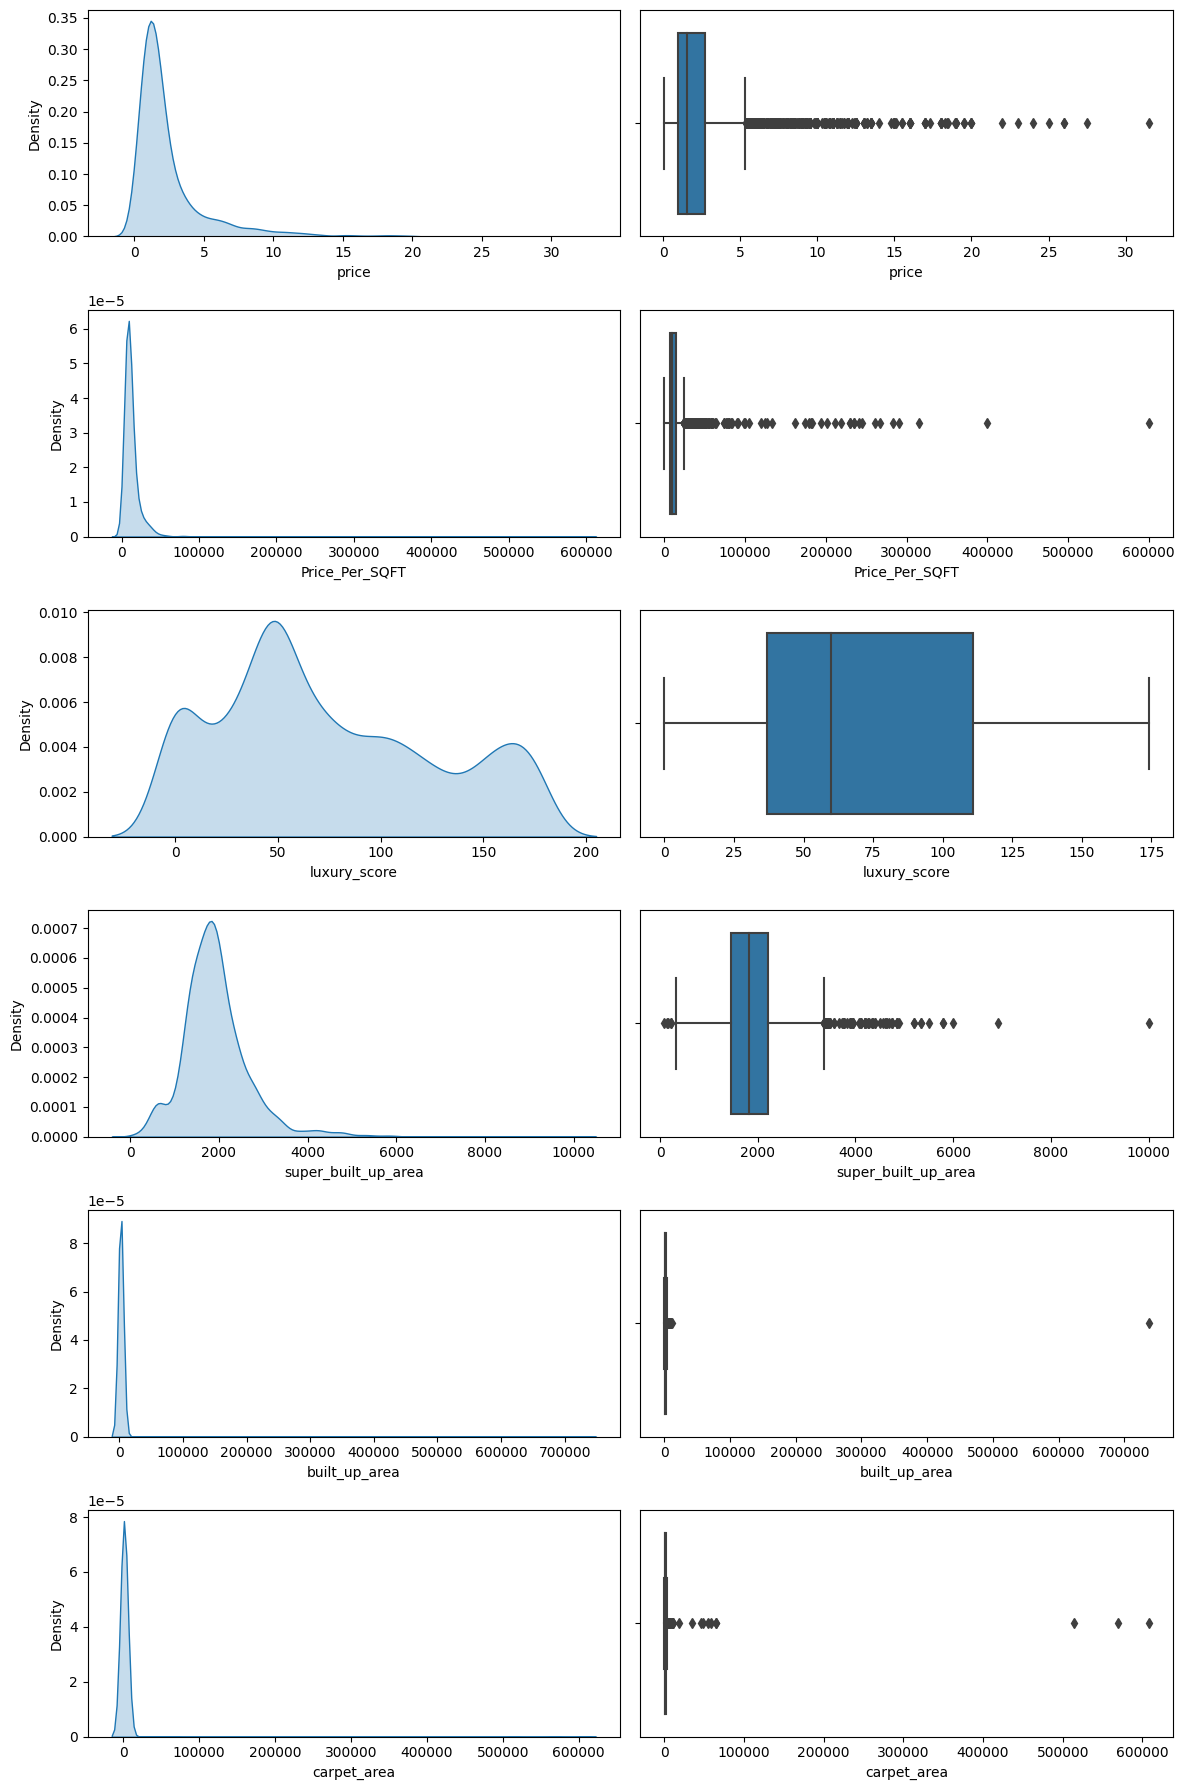

In [35]:
fig, axs = plt.subplots(6, 2, figsize=(12, 18))

# Plotting price
sns.kdeplot(df['price'], ax=axs[0, 0], shade=True)
sns.boxplot(data=df, x='price', ax=axs[0, 1])

# Plotting Price_Per_SQFT
sns.kdeplot(df['Price_Per_SQFT'], ax=axs[1,0], shade=True)
sns.boxplot(data=df, x='Price_Per_SQFT', ax=axs[1, 1])

# Plotting luxury_score
sns.kdeplot(df['luxury_score'], ax=axs[2, 0], shade=True)
sns.boxplot(data=df, x='luxury_score', ax=axs[2, 1])

# Adding more rows for additional features
sns.kdeplot(df['super_built_up_area'], ax=axs[3, 0], shade=True)
sns.boxplot(data=df, x='super_built_up_area', ax=axs[3, 1])

sns.kdeplot(df['built_up_area'], ax=axs[4, 0], shade=True)
sns.boxplot(data=df, x='built_up_area', ax=axs[4, 1])

sns.kdeplot(df['carpet_area'], ax=axs[5,0], shade=True)
sns.boxplot(data=df, x='carpet_area', ax=axs[5,1])

plt.tight_layout()
plt.show()

In [36]:
# Removing extreme outliers
indices_to_remove = df[
    (df['built_up_area'] > 700000) |
    (df['super_built_up_area'] > 6500) |
    (df['carpet_area'] > 400000) |
    (df['Price_Per_SQFT'] > 380000)
].index

# Remove rows based on the obtained indices
df = df[~df.index.isin(indices_to_remove)]
df.reset_index(drop=True,inplace=True)

In [37]:
df_outliers_count = pd.DataFrame()
features = ['price', 'Price_Per_SQFT', 'super_built_up_area', 'carpet_area', 'built_up_area']
for feature in features:

    # Getting upper and lower limit
    upper_limit, lower_limit = find_limit_skew(df[feature])

    outlier_count = (
        (df[feature] > upper_limit).sum() +
        (df[feature] < lower_limit).sum()
    )

    # Assigning values to the DataFrame
    df_outliers_count.loc[feature, 'Upper limit'] = upper_limit
    df_outliers_count.loc[feature, 'Lower limit'] = lower_limit
    df_outliers_count.loc[feature, 'Outlier count'] = outlier_count

df_outliers_count

,Upper limit,Lower limit,Outlier count
price,5.325,-1.675,421.0
Price_Per_SQFT,24442.000,-3750.000,339.0
super_built_up_area,3352.000,320.000,86.0
carpet_area,3215.625,-577.375,75.0
built_up_area,4305.000,-775.000,124.0


After the removal of extreme outliers we still have outliers left and since all the numerical features are having strong skewness in their distribution so we will be using the IQR method to access the outlier data points.

### Outlier detection and removal : `price`

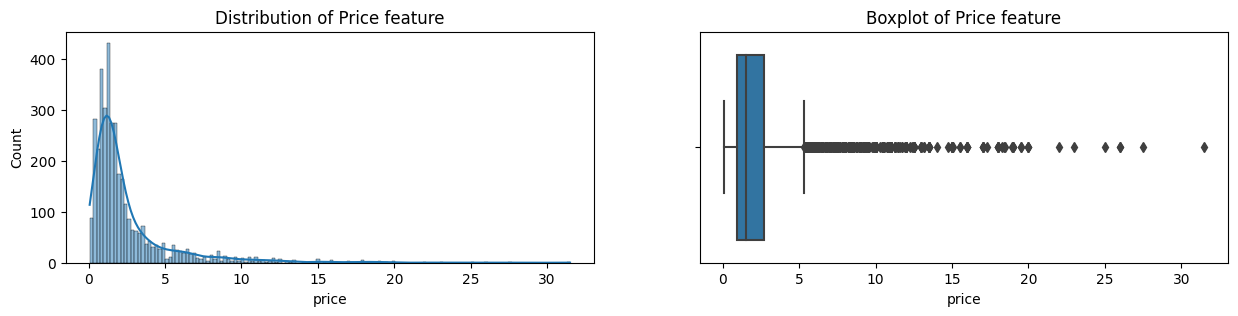

In [38]:
fig,ax = plt.subplots(1,2,figsize=(15,3))

sns.histplot(x=df['price'],kde=True,ax = ax[0])
ax[0].set_title("Distribution of Price feature")

sns.boxplot(x = df['price'],ax = ax[1])
ax[1].set_title("Boxplot of Price feature")
plt.show()

In [39]:
Up_lmt,Lw_lmt = find_limit_skew(df['price'])
Price_outliers = df[(df['price'] < Lw_lmt) | (df['price'] > Up_lmt)]

Price_outliers[Price_outliers['price']>10]['Property_Type'].value_counts()

Independent_house    110
flat                   6
Name: Property_Type, dtype: int64

In [40]:
mean_ih_price = df[(df['price']>Up_lmt) & (df['price']<20) & (df['Property_Type'] == 'Independent_house')]['price'].mean()
mean_ih_price = np.round(mean_ih_price,2)

# Cap prices of independent houses above 20 crores with the mean value
df.loc[(df['price'] > 20) & (df['Property_Type'] == 'Independent_house'), 'price'] = mean_ih_price

**Observations about `price` feature**
- The price feature is not having outiers, instead above 10 crores around **95% property are independent_houses** due to which their price is more than flats and this is also true as a fact. So we can say all independent_house data points above 10 crores can be treated as collective outliers and should not be removed.
- Since above 20 Crores there are only few properties (8) so we will simply cap the data points having more than 20 Cr price with mean of all the independent houses price between upper limit and 20 cr

### Outliers detection and removal: `Price_Per_SQFT`

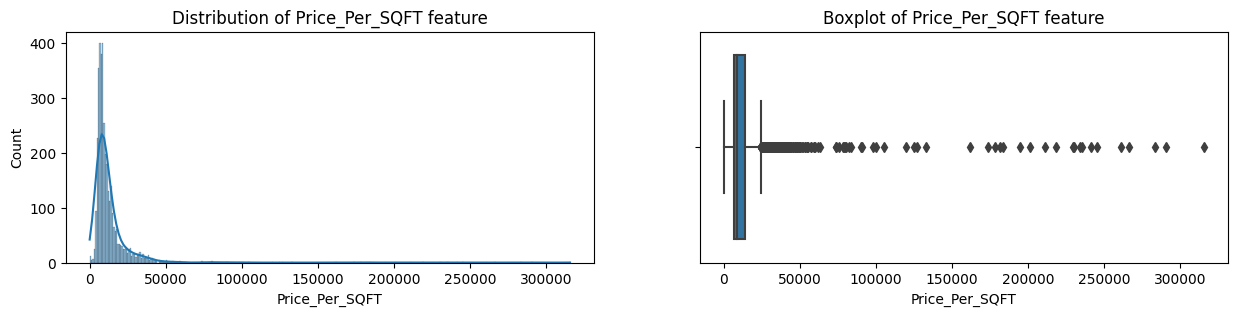

In [41]:
fig,ax = plt.subplots(1,2,figsize=(15,3))

sns.histplot(x=df['Price_Per_SQFT'],kde=True,ax = ax[0])
ax[0].set_title("Distribution of Price_Per_SQFT feature")

sns.boxplot(x = df['Price_Per_SQFT'],ax = ax[1])
ax[1].set_title("Boxplot of Price_Per_SQFT feature")
plt.show()

In [42]:
Up_lmt,Lw_lmt = find_limit_skew(df['Price_Per_SQFT'])

Outliers_pps = df[(df['Price_Per_SQFT']<Lw_lmt) | (df['Price_Per_SQFT']>Up_lmt)]
Outliers_pps['Property_Type'].value_counts()

Independent_house    311
flat                  28
Name: Property_Type, dtype: int64

In [43]:
Outliers_pps[(Outliers_pps['Area'] < 1000)]['Property_Type'].value_counts()

Independent_house    64
flat                  3
Name: Property_Type, dtype: int64

**Observations about `Price_Per_SQFT` feature**
- Out of flats and independent houses, most of properties are IH
- Out of all the outlier data points we will see that there are certain properties which are having Area less than 1000 and these are actually in term of square yards. So we will simply need to multiply them by 9 and then use them to recalculate the Price_Per_SQFT.

In [44]:
# Filter the DataFrame
Outliers_pps = df[(df['Area'] < 1000)]

# Update 'Area' column
Outliers_pps.loc[:, 'Area'] = Outliers_pps['Area'].apply(lambda x: x * 9 if x < 1000 else x)

# Update 'Price_Per_SQFT' column
Outliers_pps.loc[:, 'Price_Per_SQFT'] = round((Outliers_pps['price'] * 10000000) / Outliers_pps['Area'])

# Update the original DataFrame using .loc
df.loc[Outliers_pps.index, ['Area', 'Price_Per_SQFT']] = Outliers_pps[['Area', 'Price_Per_SQFT']]

<ipython-input-44-5ec055fc8bd1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Outliers_pps.loc[:, 'Area'] = Outliers_pps['Area'].apply(lambda x: x * 9 if x < 1000 else x)
<ipython-input-44-5ec055fc8bd1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Outliers_pps.loc[:, 'Price_Per_SQFT'] = round((Outliers_pps['price'] * 10000000) / Outliers_pps['Area'])


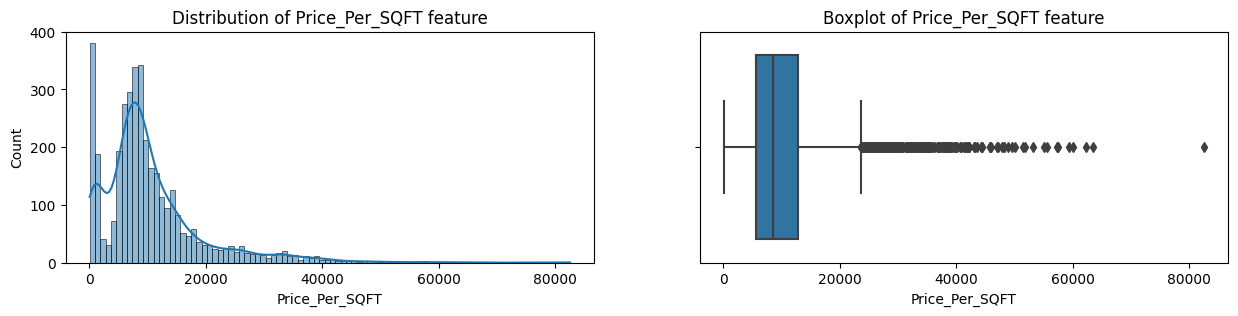

In [45]:
fig,ax = plt.subplots(1,2,figsize=(15,3))

sns.histplot(x=df['Price_Per_SQFT'],kde=True,ax = ax[0])
ax[0].set_title("Distribution of Price_Per_SQFT feature")

sns.boxplot(x = df['Price_Per_SQFT'],ax = ax[1])
ax[1].set_title("Boxplot of Price_Per_SQFT feature")
plt.show()

In [46]:
df = df[df['Price_Per_SQFT'] < 70000]
df.reset_index(drop=True,inplace=True)

### Outliers detection and removal: `bedRoom,bathroom and floorNum`

In [47]:
# Calling the functions to refractor the features
refractor_feature('bedRoom')
refractor_feature('bathroom')

In [48]:
# Value counts for the bathroom
df['bedRoom'].value_counts()

3.0     1535
2.0      966
4.0      666
5.0      202
1.0      122
6.0       73
9.0       37
8.0       29
7.0       27
12.0      26
10.0      20
16.0      11
13.0       4
19.0       2
18.0       2
14.0       1
20.0       1
21.0       1
11.0       1
Name: bedRoom, dtype: int64

In [49]:
# Value counts for the bathroom
df['bathroom'].value_counts()

3.0     1100
2.0     1078
4.0      827
5.0      295
1.0      146
6.0      119
7.0       40
9.0       39
8.0       25
12.0      20
10.0       9
16.0       7
13.0       4
18.0       4
11.0       4
20.0       3
17.0       3
14.0       2
21.0       1
Name: bathroom, dtype: int64

In [50]:
# Trimming data points having more than 10 bedRooms and bathrooms
df = df[df['bedRoom']<10.0]
df = df[df['bathroom']<10.0]

df.reset_index(drop=True,inplace=True)

### Outliers detection and removal: `luxury_score`

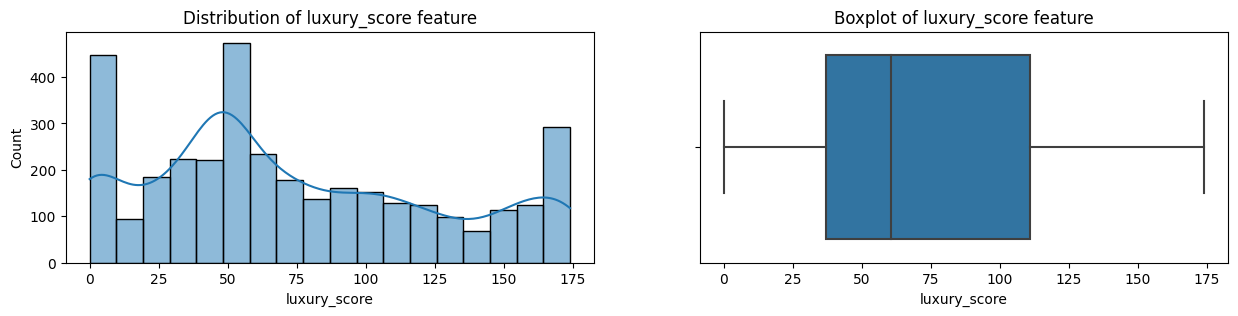

In [51]:
fig,ax = plt.subplots(1,2,figsize=(15,3))

sns.histplot(x=df['luxury_score'],kde=True,ax = ax[0])
ax[0].set_title("Distribution of luxury_score feature")

sns.boxplot(x = df['luxury_score'],ax = ax[1])
ax[1].set_title("Boxplot of luxury_score feature")
plt.show()

### Outliers detection and removal: `Super built up area, Built up area and Carpet Area`

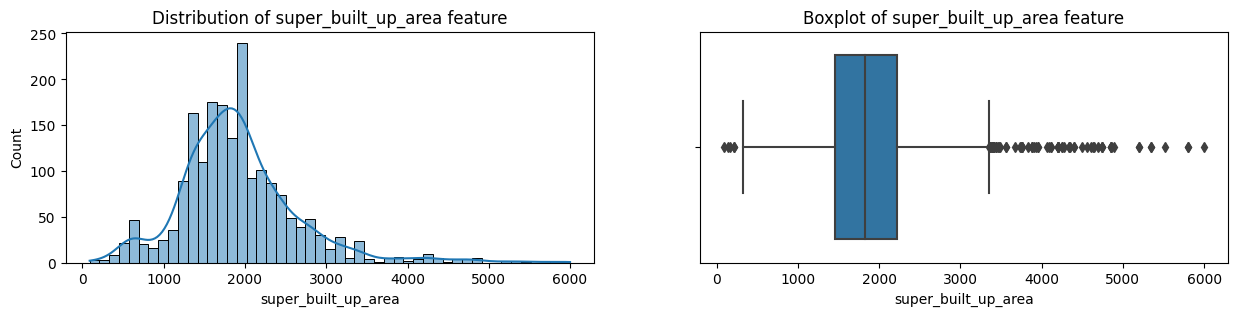

In [52]:
fig,ax = plt.subplots(1,2,figsize=(15,3))

sns.histplot(x=df['super_built_up_area'],kde=True,ax = ax[0])
ax[0].set_title("Distribution of super_built_up_area feature")

sns.boxplot(x = df['super_built_up_area'],ax = ax[1])
ax[1].set_title("Boxplot of super_built_up_area feature")
plt.show()

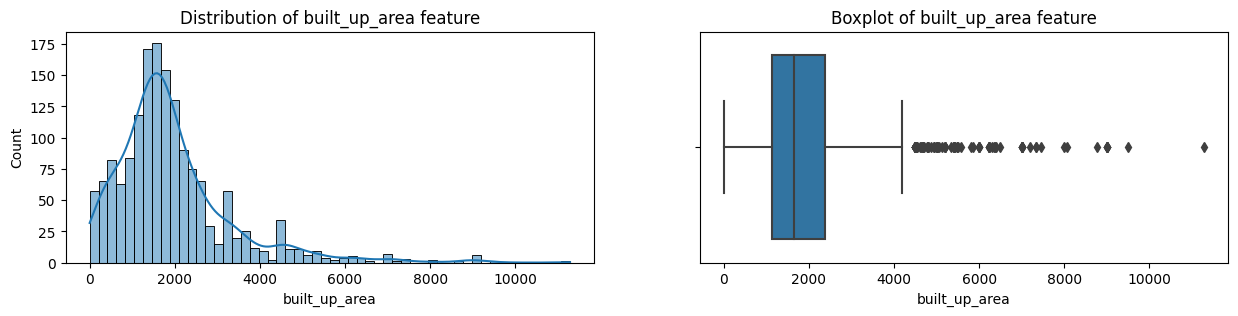

In [53]:
fig,ax = plt.subplots(1,2,figsize=(15,3))

sns.histplot(x=df['built_up_area'],kde=True,ax = ax[0])
ax[0].set_title("Distribution of built_up_area feature")

sns.boxplot(x = df['built_up_area'],ax = ax[1])
ax[1].set_title("Boxplot of built_up_area feature")
plt.show()

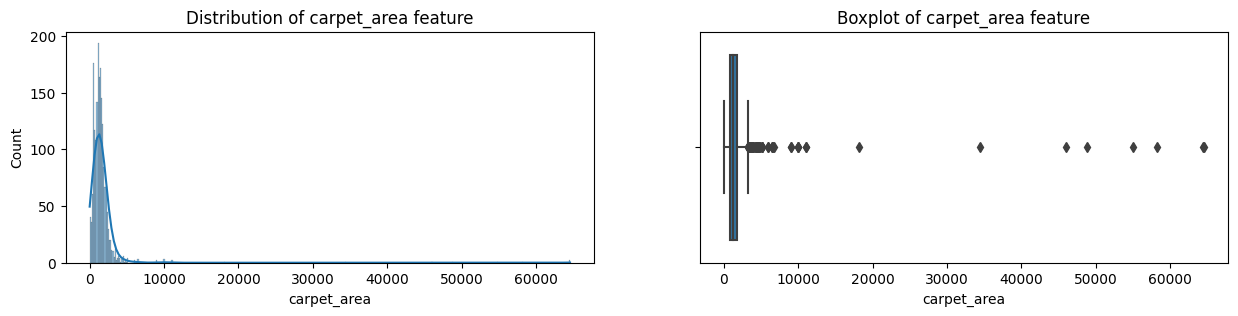

In [54]:
fig,ax = plt.subplots(1,2,figsize=(15,3))

sns.histplot(x=df['carpet_area'],kde=True,ax = ax[0])
ax[0].set_title("Distribution of carpet_area feature")

sns.boxplot(x = df['carpet_area'],ax = ax[1])
ax[1].set_title("Boxplot of carpet_area feature")
plt.show()

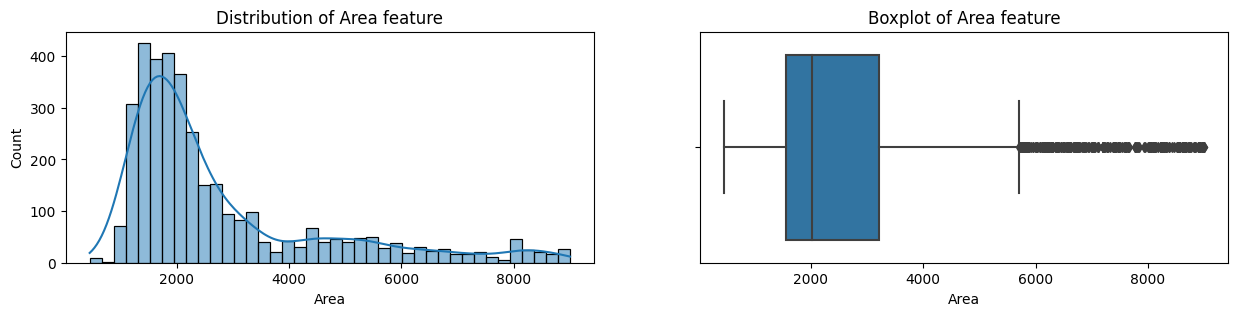

In [63]:
fig,ax = plt.subplots(1,2,figsize=(15,3))

sns.histplot(x=df['Area'],kde=True,ax = ax[0])
ax[0].set_title("Distribution of Area feature")

sns.boxplot(x = df['Area'],ax = ax[1])
ax[1].set_title("Boxplot of Area feature")
plt.show()

In [59]:
df.reset_index(drop=True,inplace=True)

# Removing extreme outliers
outlier_indices = df[
    (df['built_up_area'] > 10000) |
    (df['carpet_area'] > 8000)
].index

# Remove rows based on the obtained indices
df = df[~df.index.isin(outlier_indices)]
df.reset_index(drop=True, inplace=True)

In [62]:
# Remove rows based on the obtained indices
df = df[~df.index.isin(df[df['Area'] > 9000].index)]
df.reset_index(drop=True, inplace=True)

In [65]:
# Creating a feature called Area per bedrooms
df['Area_Per_BRoom'] = df['Area']/df['bedRoom']
df['Area_Per_BRoom'].describe()

count    3615.000000
mean     1069.209323
std      1082.635487
min        90.000000
25%       552.000000
50%       667.666667
75%       859.140717
max      8676.000000
Name: Area_Per_BRoom, dtype: float64

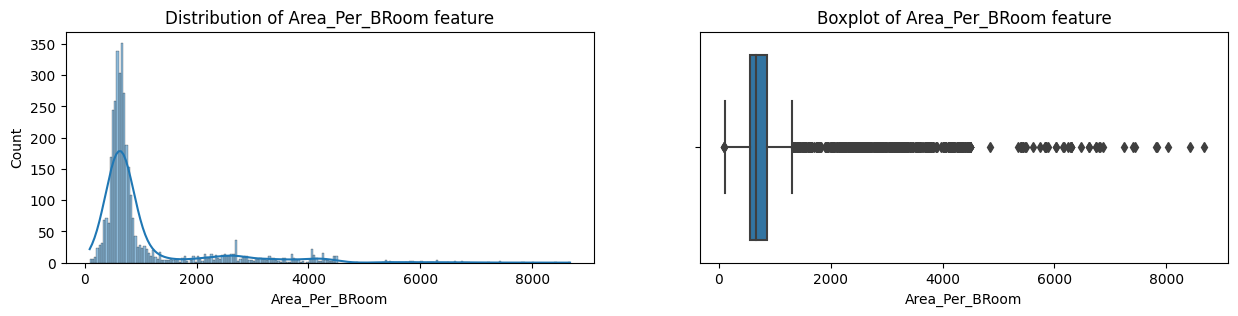

In [66]:
fig,ax = plt.subplots(1,2,figsize=(15,3))

sns.histplot(x=df['Area_Per_BRoom'],kde=True,ax = ax[0])
ax[0].set_title("Distribution of Area_Per_BRoom feature")

sns.boxplot(x = df['Area_Per_BRoom'],ax = ax[1])
ax[1].set_title("Boxplot of Area_Per_BRoom feature")
plt.show()

In [67]:
Up_lmt,Lw_lmt = find_limit_skew(df['Area_Per_BRoom'])

Area_PerBR_outliers = df[(df['Area_Per_BRoom']<Lw_lmt) | (df['Area_Per_BRoom']>Up_lmt)]
Area_PerBR_outliers.shape

(623, 27)

In [68]:
df[df['Area_Per_BRoom'] < df['Area_Per_BRoom'].quantile(0.05)][['bedRoom','Area_Per_BRoom','Property_Type']]

,bedRoom,Area_Per_BRoom,Property_Type
50,3.0,373.333333,flat
84,3.0,373.333333,flat
85,3.0,373.000000,flat
143,4.0,337.500000,flat
225,3.0,360.333333,flat
...,...,...,...
3620,4.0,362.243842,Independent_house
3621,8.0,295.873481,Independent_house
3622,5.0,289.795918,Independent_house
3623,5.0,289.796740,Independent_house


In [69]:
df[df['Area_Per_BRoom'] < df['Area_Per_BRoom'].quantile(0.05)][['bedRoom','Area_Per_BRoom','Property_Type']]['Property_Type'].value_counts()

Independent_house    144
flat                  37
Name: Property_Type, dtype: int64

Since most of the properties are Independent houses thus we can assume that there are 2 Storey or 3 Storey houses.

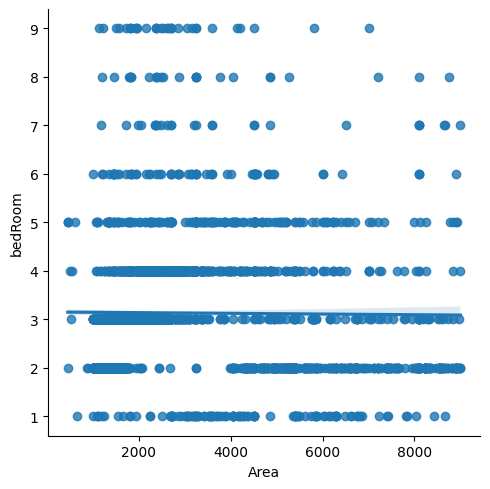

In [71]:
# To understand the relationship between ARea and bedRoom we can use scatter plot but lmplot also gives us regressionl line
sns.lmplot(data=df, x="Area", y="bedRoom")

From the lmplot we can clearly see that there are few data points which are potnetial outliers because normally the number of bedRooms should increase as per increase in Area but there are few properties where the number of bedRooms are so large for small Area

In [72]:
df[(df['Area_Per_BRoom'] < 250) & (df['bedRoom'] > 3)]['Property_Type'].value_counts()

Independent_house    42
Name: Property_Type, dtype: int64

In [73]:
# Dividing rooms with number of floor as an assumption that houses have multiple storeys
Area_PerBR_outliers = df[(df['Area_Per_BRoom'] < 250) & (df['bedRoom'] > 3)]
Area_PerBR_outliers.loc[:, 'bedRoom'] = round(Area_PerBR_outliers['bedRoom'] / Area_PerBR_outliers['floorNum'])

# Updating the values
df.update(Area_PerBR_outliers)

<ipython-input-73-a3aaff2ad3a2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Area_PerBR_outliers.loc[:, 'bedRoom'] = round(Area_PerBR_outliers['bedRoom'] / Area_PerBR_outliers['floorNum'])


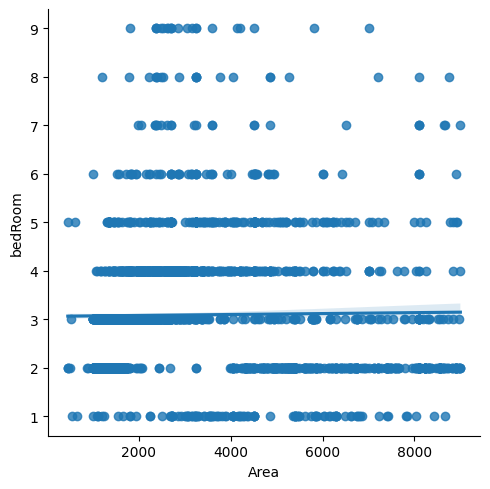

In [74]:
sns.lmplot(data=df, x="Area", y="bedRoom")

# Handling Missing values

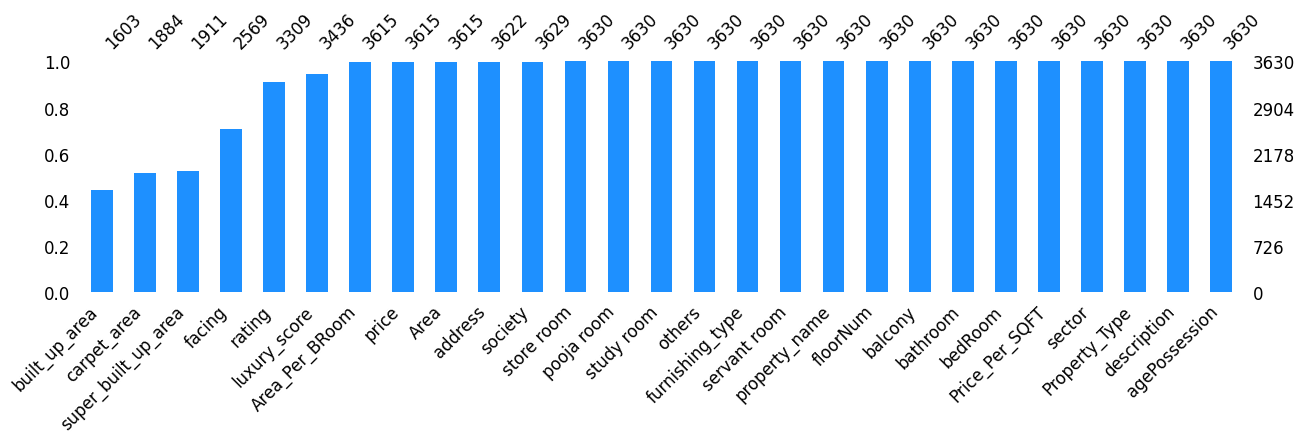

In [75]:
# Visualize missing values using a bar chart
msno.bar(df, figsize=(15, 3), color="dodgerblue", sort="ascending", fontsize=12)
plt.show()

In [76]:
df.isnull().mean()*100

property_name           0.000000
Property_Type           0.000000
society                 0.027548
sector                  0.000000
price                   0.413223
Price_Per_SQFT          0.000000
Area                    0.413223
bedRoom                 0.000000
bathroom                0.000000
balcony                 0.000000
address                 0.220386
floorNum                0.000000
facing                 29.228650
agePossession           0.000000
description             0.000000
rating                  8.842975
super_built_up_area    47.355372
built_up_area          55.840220
carpet_area            48.099174
study room              0.000000
servant room            0.000000
store room              0.000000
pooja room              0.000000
others                  0.000000
furnishing_type         0.000000
luxury_score            5.344353
Area_Per_BRoom          0.413223
dtype: float64

In [77]:
# Let's first extract features having percentage of missing values less than 5%
Less_than5_NaN = [cols for cols in df.columns if df[cols].isnull().mean() * 100 < 10 and df[cols].isnull().mean() * 100 > 0]
Less_than5_NaN

['society',
 'price',
 'Area',
 'address',
 'rating',
 'luxury_score',
 'Area_Per_BRoom']

In [79]:
# Imputing the missing value with mean and mode value
for cols in Less_than5_NaN:
    if cols == 'luxury_score':
        df[cols].fillna(df[cols].mean(),inplace=True)
    else:
        df[cols].fillna(df[cols].mode()[0],inplace=True)


- Carpet area is the net usable area of a property, excluding the thickness of the external walls, balcony, terrace, and common areas.
- Built-up area is the sum of the carpet area and the area of the external and internal walls, balcony, terrace, and staircase.
- Super built-up area is the sum of the built-up area and the common areas, such as lifts, corridors, staircases, clubhouse, and other amenities.

Super built-up area > Built-up area > Carpet area

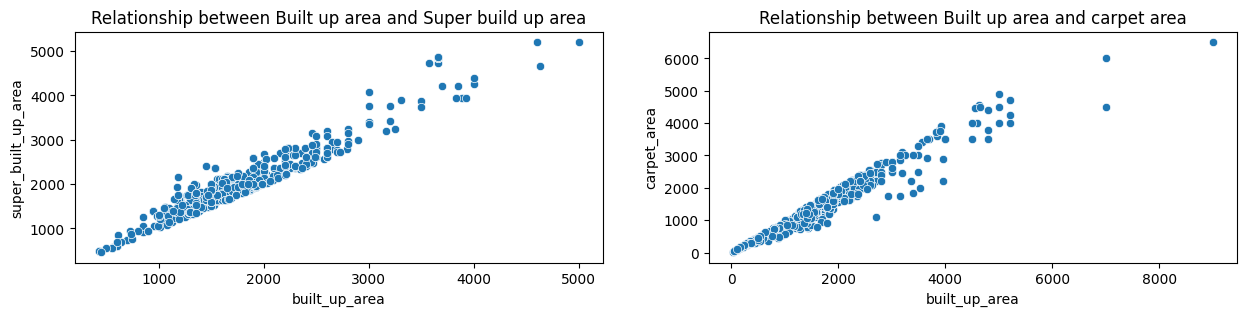

In [80]:
fig,ax = plt.subplots(1,2,figsize=(15,3))

sns.scatterplot(data = df,x='built_up_area',y='super_built_up_area',ax = ax[0])
ax[0].set_title("Relationship between Built up area and Super build up area")

sns.scatterplot(data = df,x='built_up_area',y='carpet_area',ax = ax[1])
ax[1].set_title("Relationship between Built up area and carpet area")
plt.show()

It is possible to find the value of built-up area using super built-up area if you know the ratio of super built-up area to built-up area because the ratio represents the proportion of the super built-up area that is made up of built-up area.

For example, if the ratio of super built-up area to built-up area is 1.25, this means that 1.25 square feet of super built-up area is equal to 1 square foot of built-up area. Therefore, if you know the super built-up area of a property, you can divide it by 1.25 to find the built-up area.

In [81]:
All_Areas_df = df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) | (df['carpet_area'].isnull()))]
All_Areas_df.shape

(534, 27)

In [82]:
Super_to_built_ratio = (All_Areas_df['super_built_up_area']/All_Areas_df['built_up_area']).median()
Carpet_to_built_ratio = (All_Areas_df['carpet_area']/All_Areas_df['built_up_area']).median()

Super_to_built_ratio = np.round(Super_to_built_ratio,3)
Carpet_to_built_ratio = np.round(Carpet_to_built_ratio,3)

print(Super_to_built_ratio,Carpet_to_built_ratio)

1.105 0.9


Now we have the ratios, so we can fill up the built up area values but since super built up and carpet area values are also missing so we need to careful about such data points. We will consider data points in the below mentioned manner
- Both super and carpet are present but built up is missing : sc_df
- Only super built up area is present : s_df
- Only carpet area is present : c_df

In [83]:
# Create three DataFrames with different combinations of missing values
sc_df = df[~(df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & ~(df['carpet_area'].isnull())]
s_df = df[~(df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull())]
c_df = df[(df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & ~(df['carpet_area'].isnull())]

# Fill in the missing values in the `built_up_area` column
sc_df.loc[:, 'built_up_area'].fillna(round(((sc_df['super_built_up_area']/1.105) + (sc_df['carpet_area']/0.9))/2),inplace=True)
s_df.loc[:, 'built_up_area'].fillna(round(s_df['super_built_up_area']/1.105),inplace=True)
c_df.loc[:, 'built_up_area'].fillna(round(c_df['carpet_area']/0.9),inplace=True)

# Update the original DataFrame
df.update(sc_df.loc[:, 'built_up_area'])
df.update(s_df.loc[:, 'built_up_area'])
df.update(c_df.loc[:, 'built_up_area'])

<ipython-input-83-c69e096bd404>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sc_df.loc[:, 'built_up_area'].fillna(round(((sc_df['super_built_up_area']/1.105) + (sc_df['carpet_area']/0.9))/2),inplace=True)
<ipython-input-83-c69e096bd404>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_df.loc[:, 'built_up_area'].fillna(round(s_df['super_built_up_area']/1.105),inplace=True)
<ipython-input-83-c69e096bd404>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

<Axes: xlabel='built_up_area', ylabel='price'>

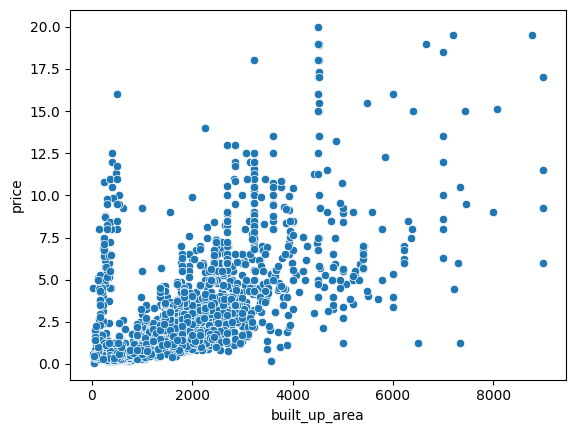

In [84]:
# Let's see built up area after imputing
sns.scatterplot(data = df,x = 'built_up_area',y = 'price')

In [85]:
# Extracting data points with built up area less than 2000 but price more than 2.5 cr
Check_df = df[(df['built_up_area'] < 2000) & (df['price'] > 2.5)][['price','Area','built_up_area']]
Check_df.sample(4)

,price,Area,built_up_area
3565,6.75,2087.973274,232.0
3543,10.80,1800.000000,250.0
3593,4.45,1264.743499,150.0
3521,9.50,2250.011842,300.0


Since the Area is justifying the price but Built_Up_Area is not so we will simply fill the built_up_area with correpsonding area values

In [86]:
Check_df['built_up_area'] = Check_df['Area']
df.update(Check_df)

In [87]:
# Fixing the undefined value in the Age possesion feature
def mode_based_imputation(row):
    if row['agePossession'] == 'Undefined':
        mode_value = df[(df['sector'] == row['sector']) & (df['Property_Type'] == row['Property_Type'])]['agePossession'].mode()[0]
        if mode_value == 'Undefined':
            # Find mode value based on same property type
            mode_value = df[(df['Property_Type'] == row['Property_Type'])]['agePossession'].mode()[0]
            return mode_value
        else:
            return mode_value
    else:
        return row['agePossession']

df['agePossession'] = df.apply(mode_based_imputation,axis=1)

In [91]:
df.isnull().sum()

property_name      0
Property_Type      0
society            0
sector             0
price              0
Price_Per_SQFT     0
bedRoom            0
bathroom           0
balcony            0
address            0
floorNum           0
agePossession      0
description        0
built_up_area      0
study room         0
servant room       0
store room         0
pooja room         0
others             0
furnishing_type    0
luxury_score       0
dtype: int64

In [90]:
# Dropping the features which are not useful further
df.drop(columns=['Area','super_built_up_area','carpet_area','Area_Per_BRoom','rating','facing'],inplace=True)

In [94]:
df.to_csv('Combined_CleanData_V3.csv',index=False)